### Helper Functions

In [30]:
import torch
from torchvision import transforms
import torchvision.transforms as transforms 
from torch.utils import data

from skimage import io
from skimage import color
from skimage.transform import resize
import matplotlib.pyplot as plt
import numpy as np


image_dimension = 108

# Usage: Take into the path to the local directory to place all the 
# stimuli left and right images into a dataloader
# stim_path: "Path to local directory"
# Returns: Dataloder (torch.utils.data.DataLoader)

def get_dataloader(stim_path):
    # stim_path: local_directory path 
    # returns: torch.utils.data.DataLoader object
    
    image_array = []
    index = np.array(["003","004","005","010","013","015","016","018","019","020",
                     "021","024","028","033","036","039","042","043","046","049",
                     "050","052","053","055","063","064","065","067","070",
                     "071","072","074","075","076","087","089","090","095",
                     "097","098"])
    
    for i, image_id in enumerate(index):

        left_image = io.imread(stim_path+"/ut_"+image_id+"/lImage"+image_id+".png")
        right_image = io.imread(stim_path+"/ut_"+image_id+"/rImage"+image_id+".png")

        left_image = resize(left_image,(image_dimension,image_dimension),anti_aliasing = True)
        right_image = resize(right_image,(image_dimension,image_dimension),anti_aliasing = True)

        left_grey_image = color.rgb2gray(left_image)
        right_grey_image = color.rgb2gray(right_image)
        grey_image = np.append(np.atleast_3d(left_grey_image), np.atleast_3d(right_grey_image), axis = 2)

        image_array.append(grey_image)
        
        
    image_array = np.array(image_array)
    labels = np.zeros(len(index))
    for i in np.arange(len(index)):
        labels[i] = i
    t = transforms.Compose([transforms.ToTensor()])
        
        
    
    dataset = ArrayDataset(image_array, labels, t)
    loader = create_data_loader(dataset, batch_size = 1)
    
    return loader

class ArrayDataset(data.Dataset):
    """
    General dataset constructor using an array of images and labels.
    
    Arguments:
        image_array : numpy array of shape (N, H, W, 2)
        labels      : numpy array of shape (N,)
        t           : torchvision.transforms instance
    """
    def __init__(self, image_array, labels, t=None):
        assert image_array.shape[0] == labels.shape[0]
        if t is not None:
            self.transforms = t
        else:
            self.transforms = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456], std=[0.229, 0.224])
            ])
        self.image_array = image_array
        self.labels = labels
        self.n_images = image_array.shape[0]

    def __getitem__(self, index):
        inputs = self.transforms(self.image_array[index,:,:,:])
        labels = self.labels[index]
        #print(inputs)
        return inputs, labels

    def __len__(self):
        return self.n_images

def create_data_loader(dataset, batch_size=30, shuffle=False):
    """
    This function creates a torch.utils.data.DataLoader object using the torch.utils.data.Dataset object

    Inputs:
        dataset    : torch.utils.data.Dataset object (see ArrayDataset above)
        batch_size : int, how many images should be loaded in each iteration
        shuffle    : boolean, shuffle the images?

    Outputs:
        loader     : torch.utils.data.DataLoader object
    """
    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size,
        shuffle=shuffle,
        pin_memory=False,
        num_workers=4
    )
    return loader

loader = get_dataloader("/Users/jackyuan/Desktop/neuroresearch/Week7/NewStimsUsed/")
print(loader.dataset.__len__)


<bound method ArrayDataset.__len__ of <__main__.ArrayDataset object at 0x7fd2173ca6a0>>


In [31]:
print(np.array(loader.dataset[0][0]).shape)

(2, 108, 108)


In [32]:
import torch.nn as nn
from collections import OrderedDict
import math


class BinocularNetwork(nn.Module):
    def __init__(self, n_filters=16, n_latent=100, relu_latent=False, k_size=19, input_size=image_dimension):
        """
        Constructs a binocular network that takes as input a stereo pair of grayscaled images.

        Arguments:
            n_filters   : number of kernels to use in first convolutional layer
            n_latent    : number of neurons prior to the classification layer
            relu_latent : whether to perform ReLU on the activations after the first
                          fully connected layer
            k_size      : size of the convolutional filter in the first layer
            input_size  : size of the input image (assumes image is square)
        """
        super(BinocularNetwork, self).__init__()
        assert k_size % 2 == 1, "Kernel/filter size must be odd!"

        self.n_filters = n_filters
        self.k_size = k_size
        self.input_size = input_size
        self.num_in_channels = 2
        
        self.simple_unit = nn.Sequential(OrderedDict([
            ("0",nn.Conv2d(
                self.num_in_channels,
                n_filters,
                kernel_size=k_size,
                stride=1,
                padding=0,
                bias=True
            )),
            ("relu",nn.ReLU(inplace=False)),
            ("Max", nn.MaxPool2d(2, stride=2, return_indices=False) 
            )])
      )

        n_units = n_filters*(self.input_size-k_size+1)*(self.input_size-k_size+1) / 4
        if relu_latent:
            self.complex_unit = nn.Sequential(
                nn.Linear(n_units, n_latent, bias=True),
                nn.ReLU(inplace=False)
            )
        else:
            self.complex_unit = nn.Linear(int(n_units), int(n_latent), bias=True)
        self.classify = nn.Linear(n_latent, 6, bias=True)

        print ("Initialize simple units with Xavier initialization.")
        self.simple_unit.apply(self._init_weights)

        print ("Initialize complex units with Xavier initialization.")
        self.complex_unit.apply(self._init_weights)
        self.classify.apply(self._init_weights)
        
        
    def _init_weights(self, m):
        if type(m) == nn.Conv2d or type(m) == nn.Linear:
            print (m)
            nn.init.xavier_uniform_(m.weight)

    def _init_zeros(self, m):
        if type(m) == nn.Linear:
            print (m)
            m.weight.data.fill_(0.)
            m.bias.data.fill_(0.)

    def forward(self, x):
        prex = x
        x = self.simple_unit(x)
        y = torch.flatten(x, start_dim=1) 
        y = self.complex_unit(y)
        #x = self.classify(x)
    
        return x,y
    

weights = torch.load("exp14_state_dict.pt",map_location=torch.device('cpu'))
state_dict = weights['state_dict']
state_dict['complex_unit.weight'] = state_dict['complex_unit.0.weight'] 
del state_dict['complex_unit.0.weight'] 
state_dict['complex_unit.bias'] = state_dict['complex_unit.0.bias'] 
del state_dict['complex_unit.0.bias']

model = BinocularNetwork()
model.load_state_dict(state_dict)


#for i,example in enumerate(loader.dataset):
#    image,label = example
#    image = image.unsqueeze(0).float()
    #print(type(image))
    #output = model(image)
    #print(output.size())
    #_, predicted = torch.max(output, 1)
    #print('Predicted: ', predicted)

   
    

Initialize simple units with Xavier initialization.
Conv2d(2, 16, kernel_size=(19, 19), stride=(1, 1))
Initialize complex units with Xavier initialization.
Linear(in_features=32400, out_features=100, bias=True)
Linear(in_features=100, out_features=6, bias=True)


<All keys matched successfully>

In [33]:
# dataloader: (dataset, batch_size, shuffle, pin_memory, num_workers)
# dataloader.dataset: (n_images, n_eyes, height, width) The dataloader containing all the 3D images
# Returns: the activations associated with the simple unit (n_images, n_pixels)
def get_simple_unit_activations(dataloader):
    
    simple_activation_bin = np.zeros([1,32400])
    
    for i,example in enumerate(dataloader.dataset):
        image,label = example
        image = image.unsqueeze(0).float()
        simple_activation_unit, complex_activation_unit = model(image)
        #plot_activation(simple_activation_unit)
    
        simple_activation_unit = simple_activation_unit.reshape(1,32400)
        simple_activation_bin = np.vstack((simple_activation_bin, simple_activation_unit.detach().numpy()))

    return simple_activation_bin[1:]

# dataloader: (dataset, batch_size, shuffle, pin_memory, num_workers)
# dataloader.dataset: (n_images, n_eyes, height, width) The dataloader containing all the 3D images
# Returns: the activations associated with the complex unit (n_images, n_pixels)
def get_complex_unit_activations(dataloader):
    
    complex_activation_bin = np.zeros([1,100])
    
    for i,example in enumerate(loader.dataset):
        image,label = example
        image = image.unsqueeze(0).float()
        simple_activation_unit, complex_activation_unit = model(image)
        #plot_activation(simple_activation_unit)
    
        complex_activation_bin = np.vstack((complex_activation_bin, complex_activation_unit.detach().numpy()))


    return complex_activation_bin[1:]
 
simple_activation_bin = get_simple_unit_activations(loader)
complex_activation_bin = get_complex_unit_activations(loader)

print(simple_activation_bin.shape, complex_activation_bin.shape)

(40, 32400) (40, 100)


In [34]:
def get_simple_complex_unit_activations_2d(dataloader):
    # loader: Containing all the 40 images
    # Returns: The bin of simple_unit_extractions and complex_unit_extractions\
    # as if only 2D images were passed in.
    
    simple_unit_feats_bin_2d = np.zeros([1,32400])
    complex_unit_feats_bin_2d = np.zeros([1,100])
    
    for i,example in enumerate(dataloader.dataset):
        image,label = example
        image = image.unsqueeze(0).float()
    
        if np.random.rand() < 0.5:
            image[0,0] = image [0,1]
        else:
            image[0,1] = image[0,0]
        
        simple_unit_2d, complex_unit_2d = model(image)

        #plot_activation(simple_unit_2d)
    
        simple_unit_2d = simple_unit_2d.reshape(1,32400)
        simple_unit_feats_bin_2d = np.vstack((simple_unit_feats_bin_2d, simple_unit_2d.detach().numpy()))
    
        complex_unit_feats_bin_2d = np.vstack((complex_unit_feats_bin_2d, complex_unit_2d.detach().numpy()))

        #print("The dimensions of the activation of simple unit is",simple_activation_bin[1].shape,

    simple_unit_feats_bin_2d = simple_unit_feats_bin_2d[1:]
    complex_unit_feats_bin_2d = complex_unit_feats_bin_2d[1:]
    
    return simple_unit_feats_bin_2d, complex_unit_feats_bin_2d
    

In [35]:
import sklearn
from sklearn.decomposition import PCA

# data:(n_images, n_pixels)
# ncomponents: (number of PCA Dimension)
# Returns: PCA-transformed datamatrix (n_images, ncomponents)
def perform_pca(data_for_pca, ncomponents):
    
    pca_data = PCA(n_components = ncomponents)
    pca_data.fit(data_for_pca)
    transformed_data = pca_data.transform(data_for_pca)
    #final_data = pca_data.components_@data_for_pca.T
    
    print(ncomponents, " accounted for {} variance".format(sum(pca_data.explained_variance_ratio_)))
    
    return transformed_data


### Plotting GFP and Timeseries

In [36]:
EEG = np.load('Live3D_byScenes_trialAvg.npy')

print("Dimensions of GFP time series are", EEG.shape,
     ", and ", EEG.shape[0], " stimuli were used.")

Dimensions of GFP time series are (40, 2, 315, 128) , and  40  stimuli were used.


In [37]:
print("The sampling rate determines the x-axis of the graph, which would\
affect our understanding of how fast was the entire spike process.\
The sampling rate would be 500 if the time sample is 2ms. \
There are 315 time samples, and if the EEG time series were \
750 ms, then the sampling rate would have to be 420 since \
(1000/(750/315)) = 420")

The sampling rate determines the x-axis of the graph, which wouldaffect our understanding of how fast was the entire spike process.The sampling rate would be 500 if the time sample is 2ms. There are 315 time samples, and if the EEG time series were 750 ms, then the sampling rate would have to be 420 since (1000/(750/315)) = 420


In [38]:
sampling_rate = 420

conversion = 1000 / sampling_rate

# data: (n_stim, n_time, n_electrodes)
# returns: (n_stim, n_time(averaged)), the standard deviation across all electrodes at certain times
def compute_gfp(gfp_data):
    print("n_stim: ", gfp_data.shape[0])
    print("n_time: ", gfp_data.shape[1])
    print("n_chan: ", gfp_data.shape[2])
    return np.sqrt(np.sum(np.square(gfp_data - np.nanmean(gfp_data, axis=2, keepdims=True)), axis=2) / gfp_data.shape[2])

# gfp: (n_times,)
# color: color for time series
# label: label for time series
# Units of time series are in voltages
# Plotting the average of all electrodes, pictures acorss all timestamps.
def plot_gfp(gfp, color, label, fig = None):
   
    fs = 20
    time = np.arange(gfp.shape[0]) * conversion
    
    if fig is None:
        fig = plt.figure(figsize=(10,6))
    
    plt.plot(time, gfp * 1e6, color = color, label = label)
    plt.xlabel("Time(ms)", fontsize = fs)
    plt.ylabel("Global Field Power (GFP) ($\mu Voltage$)", fontsize = fs)
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.legend(fontsize=fs)
    
    return fig
    
# time_series: (n_times,)
# color: color for time series plot
# label: label for time series
# Units of time series are in voltages
# Plotting the activities of one specific electrode across all images

def plot_time_series(time_series, color, label, fig = None):
    fs = 20
    time = np.arange(time_series.shape[0]) * conversion
    
    if fig is None:
        fig = plt.figure(figsize=(10,6))
    
    plt.plot(time, time_series * 1e6, color = color, label = label)
    plt.xlabel("Time(ms)", fontsize = fs)
    plt.ylabel("Voltage ($\mu Voltage$)", fontsize = fs)
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.legend(fontsize=fs)
    
    return fig
    

(40, 2, 315, 128)
(2, 315, 128)


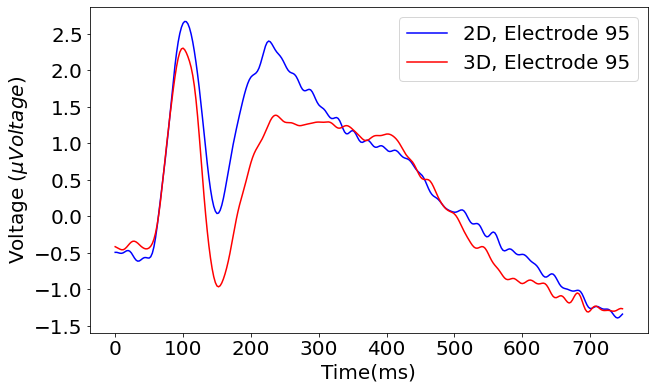

In [39]:
print(EEG.shape)

EEG_avg = EEG.mean(axis=0)
print(EEG_avg.shape)

electrode_idx = 95
fig = plot_time_series(EEG_avg[0,:,electrode_idx], "blue", "2D, Electrode {}".format(electrode_idx))
_ = plot_time_series(EEG_avg[1,:,electrode_idx], "red", "3D, Electrode {}".format(electrode_idx), fig=fig)


In [40]:
# Computing GFP for each stimuli
gfp_2d = compute_gfp(EEG[:,0,:,:])
gfp_3d = compute_gfp(EEG[:,1,:,:])

print(gfp_2d.shape, gfp_3d.shape)

# Averaging across all stinuli
gfp_2d_avg = np.mean(gfp_2d, axis = 0)
gfp_3d_avg = np.mean(gfp_3d, axis = 0)
print(gfp_2d_avg.shape)

n_stim:  40
n_time:  315
n_chan:  128
n_stim:  40
n_time:  315
n_chan:  128
(40, 315) (40, 315)
(315,)


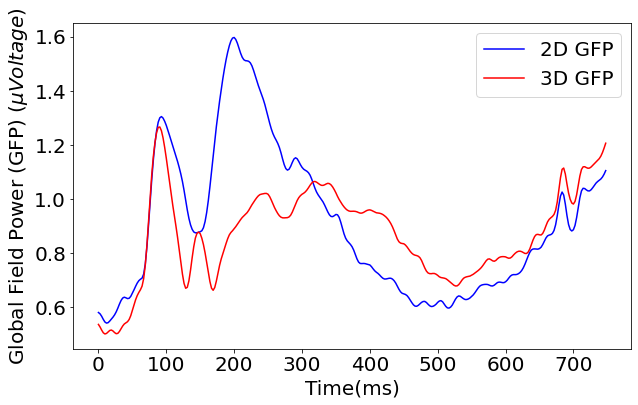

In [41]:
fig = plot_gfp(gfp_2d_avg, "blue", "2D GFP")
_ = plot_gfp(gfp_3d_avg, "red", "3D GFP", fig = 1)

### Rankings of Stimuli

In [42]:
index = np.array(["003","004","005","010","013","015","016","018","019","020",
                     "021","024","028","033","036","039","042","043","046","049",
                     "050","052","053","055","063","064","065","067","070",
                     "071","072","074","075","076","087","089","090","095",
                     "097","098"])

(40,)
[25 39] [11  9]
The time-series GFP of graph of the top_two_ind are going to look much more further apart for each timestamp than compared to the time-series GFP of the bot_two_ind


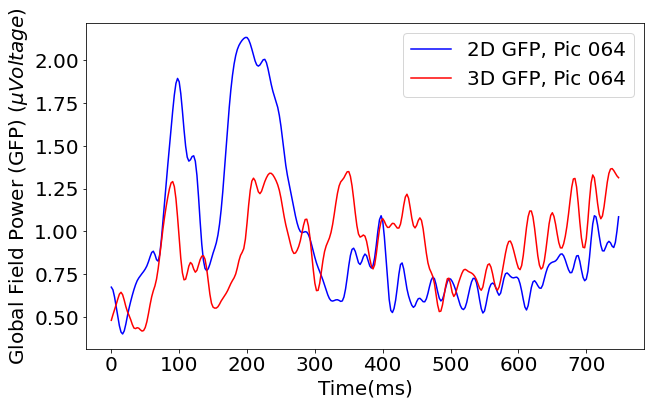

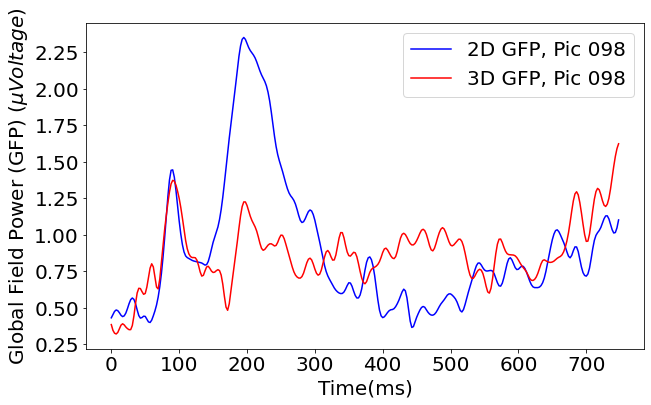

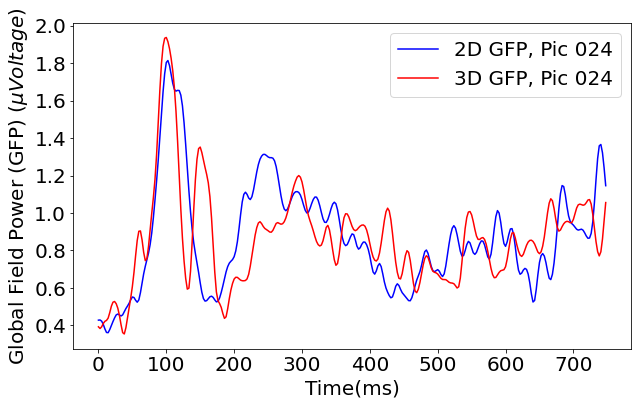

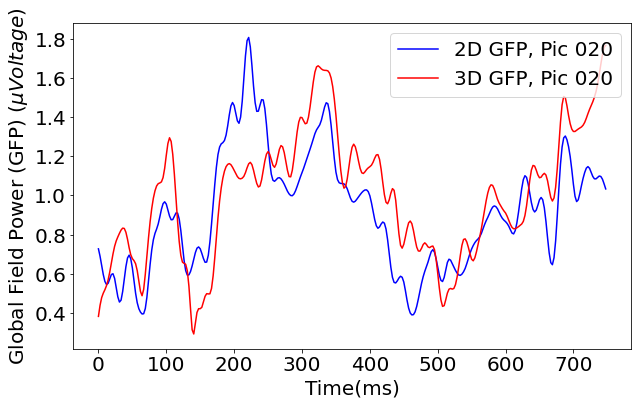

In [43]:
import operator 

gfp_difference = np.linalg.norm(gfp_2d - gfp_3d, axis = 1)

print(gfp_difference.shape)

top_two_ind = np.argpartition(gfp_difference,-2)[-2:]
bot_two_ind = np.argpartition(gfp_difference,2)[:2]
print(top_two_ind, bot_two_ind)

print("The time-series GFP of graph of the top_two_ind are going to look\
 much more further apart for each timestamp than compared to the \
time-series GFP of the bot_two_ind")

fig = plot_gfp(gfp_2d[top_two_ind[0]], "blue", "2D GFP, Pic {}".format(index[top_two_ind[0]]))
_ = plot_gfp(gfp_3d[top_two_ind[0]], "red", "3D GFP, Pic {}".format(index[top_two_ind[0]]), fig = 1)
fig = plot_gfp(gfp_2d[top_two_ind[1]], "blue", "2D GFP, Pic {}".format(index[top_two_ind[1]]))
_ = plot_gfp(gfp_3d[top_two_ind[1]], "red", "3D GFP, Pic {}".format(index[top_two_ind[1]]), fig = 1)

fig = plot_gfp(gfp_2d[bot_two_ind[0]], "blue", "2D GFP, Pic {}".format(index[bot_two_ind[0]]))
_ = plot_gfp(gfp_3d[bot_two_ind[0]], "red", "3D GFP, Pic {}".format(index[bot_two_ind[0]]), fig = 1)
fig = plot_gfp(gfp_2d[bot_two_ind[1]], "blue", "2D GFP, Pic {}".format(index[bot_two_ind[1]]))
_ = plot_gfp(gfp_3d[bot_two_ind[1]], "red", "3D GFP, Pic {}".format(index[bot_two_ind[1]]), fig = 1)




#index, value = max(enumerate(gfp_difference), key=operator.itemgetter(1))


In [44]:
simple_unit_activation_3d = get_simple_unit_activations(loader)
complex_unit_activation_3d = get_complex_unit_activations(loader)

simple_unit_activation_2d, complex_unit_activation_2d = get_simple_complex_unit_activations_2d(loader)

#print(simple_unit_activation.shape, complex_unit_activation.shape, simple_unit_activation_2d.shape, complex_unit_activation_2d.shape)

simple_difference = np.linalg.norm(simple_unit_activation_2d - simple_unit_activation_3d, axis = 1)
complex_difference = np.linalg.norm(complex_unit_activation_2d - complex_unit_activation_3d, axis = 1)


In [45]:
from scipy import stats
simple_difference_rank = np.argsort(simple_difference)
complex_difference_rank = np.argsort(complex_difference)
gfp_difference_rank = np.argsort(gfp_difference)

print("Pearson rank order correlation between simple_activation and gfp",stats.spearmanr(simple_difference_rank,gfp_difference_rank),"\n")
print("Pearson rank order correlation between complex_activation and gfp",stats.spearmanr(complex_difference_rank,gfp_difference_rank),"\n")
print("Pearson rank order correlation between complex_activation and simple_activation",stats.spearmanr(complex_difference_rank,simple_difference_rank))

#print(simple_difference_rank)
#print(complex_difference_rank)
#print(gfp_difference_rank)

Pearson rank order correlation between simple_activation and gfp SpearmanrResult(correlation=0.012945590994371484, pvalue=0.9368082579478432) 

Pearson rank order correlation between complex_activation and gfp SpearmanrResult(correlation=-0.023452157598499064, pvalue=0.8857841788913227) 

Pearson rank order correlation between complex_activation and simple_activation SpearmanrResult(correlation=-0.251031894934334, pvalue=0.118180202921099)


### Trying to improve PearsmanR coeff by performing PCA

In [46]:
print(simple_unit_activation_2d.shape)
pca_simple_unit_activation_2d = perform_pca(simple_unit_activation_2d,25)
pca_simple_unit_activation_3d = perform_pca(simple_unit_activation_3d,25)

pca_complex_unit_activation_2d = perform_pca(complex_unit_activation_2d,25)
pca_complex_unit_activation_3d = perform_pca(complex_unit_activation_3d,25)

pca_simple_difference = np.linalg.norm(pca_simple_unit_activation_2d - pca_simple_unit_activation_3d, axis = 1)
pca_complex_difference = np.linalg.norm(pca_complex_unit_activation_2d - pca_complex_unit_activation_3d, axis = 1)

pca_simple_difference_rank = np.argsort(pca_simple_difference)
pca_complex_difference_rank = np.argsort(pca_complex_difference)

print("(PCA) Pearson rank order correlation between simple_activation and gfp",stats.spearmanr(pca_simple_difference_rank,gfp_difference_rank),"\n")
print("(PCA) Pearson rank order correlation between complex_activation and gfp",stats.spearmanr(pca_complex_difference_rank,gfp_difference_rank),"\n")
print("(PCA) Pearson rank order correlation between complex_activation and simple_activation",stats.spearmanr(pca_complex_difference_rank,pca_simple_difference_rank))


(40, 32400)
25  accounted for 0.9256516323350877 variance
25  accounted for 0.9197213243384259 variance
25  accounted for 0.9871384446519728 variance
25  accounted for 0.9829905633970853 variance
(PCA) Pearson rank order correlation between simple_activation and gfp SpearmanrResult(correlation=-0.3630393996247655, pvalue=0.02131082003971063) 

(PCA) Pearson rank order correlation between complex_activation and gfp SpearmanrResult(correlation=-0.04652908067542214, pvalue=0.7755685490633211) 

(PCA) Pearson rank order correlation between complex_activation and simple_activation SpearmanrResult(correlation=-0.34840525328330213, pvalue=0.027582123218315425)


In [47]:
a = (np.abs(simple_unit_activation_2d - simple_unit_activation_3d))/\
(np.mean(simple_unit_activation_2d + simple_unit_activation_3d, axis = 0))
b = np.mean(a,axis = 1)

print("Ratio between the differences of the 2D and 3D simple extractions and\
the mean extraction values of 2D and 3D for 40 images: ", b, 
     "and '\033[1m' the mean difference/mean ratio is: %.2f" %(b.mean()*100), "%'\033[0m'")

a = (np.abs(complex_unit_activation_2d - complex_unit_activation_3d))/\
(np.mean(complex_unit_activation_2d + complex_unit_activation_3d, axis = 0))
b = np.mean(a,axis = 1)

print("Ratio between the differences of the 2D and 3D complex extractions and\
the mean extraction values of 2D and 3D for 40 images: ", b, 
     "and '\033[1m' the mean difference/mean ratio is: %.2f" %(b.mean()*100), "%")


Ratio between the differences of the 2D and 3D simple extractions andthe mean extraction values of 2D and 3D for 40 images:  [0.21967786 0.16943337 0.12953839 0.18075285 0.09213467 0.09327528
 0.10238929 0.35022696 0.42590877 0.08117796 0.09354696 0.0774236
 0.27777329 0.06714925 0.13320769 0.16149377 0.13973438 0.14831711
 0.13050119 0.09167954 0.12582102 0.15398778 0.18308227 0.11847154
 0.35311247 0.22618638 0.35503797 0.17137743 0.2822889  0.2327366
 0.25192248 0.14717819 0.12427672 0.48592595 0.42762049 0.3441467
 0.50665709 0.09017939 0.21811554 0.1209364 ] and '' the mean difference/mean ratio is: 20.21 %''
Ratio between the differences of the 2D and 3D complex extractions andthe mean extraction values of 2D and 3D for 40 images:  [0.11181133 0.10496351 0.09248641 0.07634518 0.01689745 0.03029468
 0.08398875 0.31198732 0.64786052 0.01448852 0.04623708 0.03581065
 0.18640686 0.02981506 0.03710204 0.0049445  0.02814914 0.08617869
 0.08459896 0.02951914 0.06735613 0.01579203 0.1067

### Variance for 3D GFP

(40, 315)
The dimensions of my data vector of variances for each time sample is 315


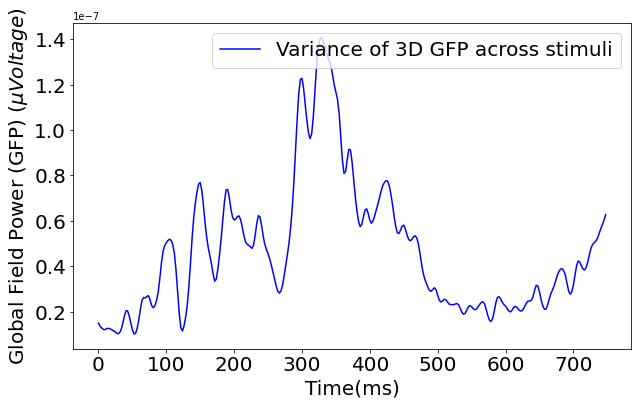

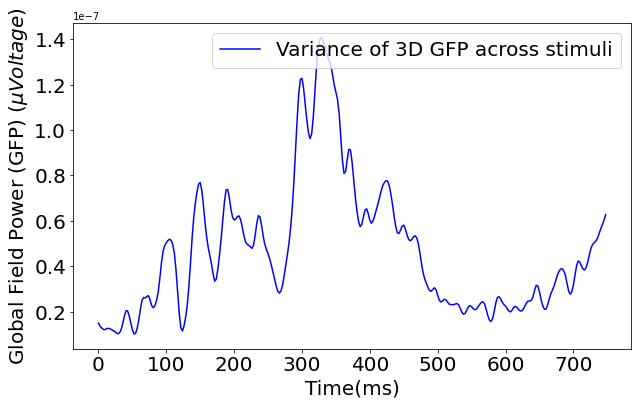

In [48]:
print(gfp_3d.shape)
gfp_3d_variance = np.var(gfp_3d, axis = 0)

print("The dimensions of my data vector of variances for each time sample is", len(gfp_3d_variance))

plot_gfp(gfp_3d_variance, "Blue", "Variance of 3D GFP across stimuli")


### Preparing for Linear Regression

In [49]:
plt.close()

print("The Lambda parameter is the penalty term that\
is used to weight the input features to determine how much of the \
features gets to influence the final output. The Lambda\
parameter would be larger for more important features, \
and would be 0 or close to 0 for non-important features.")

print("L1 regularization selects feature, where it assigns insignificant\
features 0 weight and useful features with a non-zero weight. L2 regularization\
on the other hand clumps all the features together and assigns a \
relatively small weight to all of it. L2 is better for more \
complex, equal-weighted data patterns, but L1 is better for \
simpler features selections and is robust for outliers.")

The Lambda parameter is the penalty term thatis used to weight the input features to determine how much of the features gets to influence the final output. The Lambdaparameter would be larger for more important features, and would be 0 or close to 0 for non-important features.
L1 regularization selects feature, where it assigns insignificantfeatures 0 weight and useful features with a non-zero weight. L2 regularizationon the other hand clumps all the features together and assigns a relatively small weight to all of it. L2 is better for more complex, equal-weighted data patterns, but L1 is better for simpler features selections and is robust for outliers.


### pca function for training and testing data

In [50]:
def perform_pca_linear_regr(train, test, ncomponents):
    
    # train, test:(n_samples, n_features)
    # ncomponents: (number of PCA Dimension)
    # Returns: PCA-transformed datamatrix (n_images, ncomponents)
    # Purpose: Estimate the principal components using the training dataset then projects the testing data onto the same components
    
    pca_data = PCA(n_components = ncomponents)
    pca_data.fit(train)
    train_pca = pca_data.transform(train)
    test_pca = pca_data.transform(test)
    
    #print(ncomponents, " accounted for {} variance".format(sum(pca_data.explained_variance_ratio_)))
    
    return train_pca, test_pca


# Linear Regression

In [78]:
np.random.seed(1)

from sklearn import datasets, linear_model, preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import RidgeCV, ElasticNetCV
from sklearn.model_selection import LeaveOneOut, cross_val_score, ShuffleSplit
from sklearn.preprocessing import StandardScaler

def linearmodel_GFP(X_activation, Y_GFP):
    # EEG_X_3d: (n_samples, n_features)
    # pca_simple_unit_activation_3d: (n_samples,)
    # Returns the r2 score for the model
    
    #X
    X_scaled = preprocessing.scale(X_activation)
    X_train_scaled = X_scaled[:-10]
    X_test_scaled = X_scaled[-10:]
    
    pca_X_train, pca_X_test = perform_pca_linear_regr(X_train_scaled, X_test_scaled, 25)

    #Y
    Y_train = Y_GFP[:-10]
    Y_test = Y_GFP[-10:]
    
    #print(pca_X_train.shape, Y_train.shape, pca_X_test.shape, Y_test.shape)
    
    #cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)

    alphas=[0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1, 2, 10, 50, 100, 500, 1000, 2000]
    regr = RidgeCV(alphas = alphas, cv = 10).fit(pca_X_train,Y_train)
    
    best_alpha = [regr.alpha_]
    print(best_alpha[0])

    #regr = RidgeCV(alphas = best_alpha, cv = 10).fit(pca_X_train,Y_train)
    
    return regr.score(pca_X_test,Y_test)


    #get_cv_scores(ridge)
    
    #print("regr.score", regr.score(X,Y))
    #regr.fit(pca_activation_3d_train, EEG_3d_train)
    
    #MSEs = cross_val_score(regr, X, Y, scoring='neg_mean_squared_error', cv=5)
    
    #print("Coefficients: ",regr.coef_, " and intercept: ", regr.intercept_)
    
    #print("hello",regression.score(pca_simple_unit_activation_3d_test, EEG_3d_test))

    #EEG_3d_pred = regr.predict(pca_activation_3d_test)
    #print(EEG_3d_pred.shape)

    #print((EEG_3d_pred - EEG_3d_test)/(np.mean((EEG_3d_pred + EEG_3d_test), axis = 0)))

    #print("Coefficients: \n", regression.coef_)

    # The mean squared error
    #print('Mean squared error: %.2f'
    #      % mean_squared_error(EEG_3d_test, EEG_3d_pred))
    # The coefficient of determination: 1 is perfect prediction
    #print('Coefficient of determination: %.2f'
    #      % r2_score(EEG_3d_test, EEG_3d_pred))
    
    #print("Best alpha: ", regr.alpha_)
    #print('Coefficient of determination:', regr.coef_)
    
    



In [79]:
def best_correlation(correlation_array, k):
    # correlation_array: (315,) of r2_scores
    # k: int, the number of indexes to return
    # Returns the time_stamp_points that have the largest r2 scores closest to 1

    correlation_array = np.array(correlation_array)
    correlation_array = correlation_array[np.where(correlation_array < 1)]
    
    return np.argsort(correlation_array)[-k:]
    

### 3D - 2D extractions to predict 3D - 2D GFP

In [80]:
#X
simple_activation_2d = simple_unit_activation_2d
simple_activation_3d = simple_unit_activation_3d
complex_activation_2d = complex_unit_activation_2d
complex_activation_3d = complex_unit_activation_3d
print("Shape of simple_activation_2d and simple_activation_3d", simple_activation_2d.shape, simple_activation_3d.shape)
print("Shape of complex_activation_2d and complex_activation_3d", complex_activation_2d.shape, complex_activation_3d.shape)

#Y
gfp_2d = gfp_2d
gfp_3d = gfp_3d
print("Shape of gfp_2d and gfp_3d", gfp_2d.shape, gfp_3d.shape)

simple_correlation, complex_correlation = [], []

for timestamp in np.arange(gfp_2d.shape[1]):
    simple_correlation.append(linearmodel_GFP((simple_activation_3d - simple_activation_2d), (gfp_3d[:,timestamp] - gfp_2d[:,timestamp])))
    complex_correlation.append(linearmodel_GFP((complex_activation_3d - complex_activation_2d), (gfp_3d[:,timestamp] - gfp_2d[:,timestamp])))

                               
best_simple_timestamps = best_correlation(simple_correlation, 10)
best_complex_timestamps = best_correlation(complex_correlation, 10)
                              

Shape of simple_activation_2d and simple_activation_3d (40, 32400) (40, 32400)
Shape of complex_activation_2d and complex_activation_3d (40, 100) (40, 100)
Shape of gfp_2d and gfp_3d (40, 315) (40, 315)
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
1000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
100.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
50.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
50.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
50.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
100.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
100.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
1000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)

(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
500.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
100.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
500.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30,

2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
100.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
50.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
50.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
50.0
(30, 25) (30,) (10, 25) (10,)
1000.0
(30, 25) (30,) (10, 25) (10,)
10.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
50.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
500.0
(30, 2

Best simple_timestamps (ms): [116 262 263 290 133 291 137 134 135 136]
Best complex_timestamps (ms): [193 182 191 178  88 192 181  89 179 180]
<class 'numpy.int64'>
Best 10 R2 values of simple_extraction
[0.20707626 0.21309845 0.21647246 0.22002348 0.22729601 0.23095636
 0.23135569 0.24352803 0.25364943 0.25749345]
Best 10 R2 values of complex_extraction
[0.13545145 0.1447997  0.18620487 0.19636258 0.20331834 0.20883825
 0.20946227 0.22976302 0.24070248 0.24256552]
<class 'numpy.float64'>
<class 'numpy.float64'>


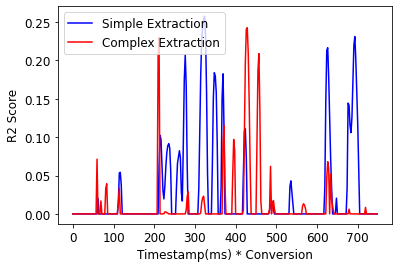

In [81]:
print("Best simple_timestamps (ms):", best_simple_timestamps)
print("Best complex_timestamps (ms):", best_complex_timestamps)

print(type(best_simple_timestamps[0]))
print("Best 10 R2 values of simple_extraction")
print(np.array(simple_correlation)[(best_simple_timestamps.astype(int))])

print("Best 10 R2 values of complex_extraction")
print(np.array(complex_correlation)[(best_complex_timestamps.astype(int))])

plot_R2(np.arange(gfp_3d.shape[1]), simple_correlation, color = "blue", label = "Simple Extraction", block_neg = 1)
plot_R2(np.arange(gfp_3d.shape[1]), complex_correlation, color = "red", label = "Complex Extraction", block_neg = 1)
plt.show()

### Using 3D extractions to predict 3D GFP

In [82]:
#X
simple_activation_3d = simple_unit_activation_3d
complex_activation_3d = complex_unit_activation_3d
print("Shape of simple_activation_3d and complex_activation_3d", simple_activation_3d.shape, complex_activation_3d.shape)

#Y
gfp_3d = gfp_3d
print("Shape of gfp_3d", gfp_3d.shape)

simple_3d_correlation, complex_3d_correlation = [], []

for timestamp in np.arange(gfp_3d.shape[1]):
    simple_3d_correlation.append(linearmodel_GFP(simple_activation_3d, gfp_3d[:,timestamp]))
    complex_3d_correlation.append(linearmodel_GFP(complex_activation_3d, gfp_3d[:,timestamp]))

                               
best_simple_3d_timestamps = best_correlation(simple_3d_correlation, 10)
best_complex_3d_timestamps = best_correlation(complex_3d_correlation, 10)


Shape of simple_activation_3d and complex_activation_3d (40, 32400) (40, 100)
Shape of gfp_3d (40, 315)
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
500.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
500.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
500.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
100.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
100.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
100.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,)

2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
1000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
1000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2

2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
100.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
100.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
100.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
500.0
(30, 25) (30,) (10, 25) (10,)
2000.0
(30, 25) (30,) (10, 25) (10,)
100.0

Best simple_timestamps (ms): [241 302 208 243 205 304 303 242 207 206]
Best complex_timestamps (ms): [250 237  96 253 224 238 225 226 252 251]
<class 'numpy.int64'>
Best 10 R2 values of simple_extraction
[0.19541005 0.20776681 0.21113704 0.22364785 0.24045699 0.24104764
 0.24589609 0.25110858 0.2684987  0.27426826]
Best 10 R2 values of complex_extraction
[0.10991958 0.14297718 0.15138114 0.15509455 0.20268252 0.21760294
 0.26347233 0.2907301  0.32404898 0.37691098]
<class 'numpy.float64'>
<class 'numpy.float64'>


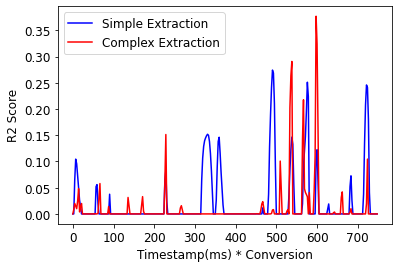

In [83]:
print("Best simple_timestamps (ms):", best_simple_3d_timestamps)
print("Best complex_timestamps (ms):", best_complex_3d_timestamps)

print(type(best_simple_3d_timestamps[0]))
print("Best 10 R2 values of simple_extraction")
print(np.array(simple_3d_correlation)[(best_simple_3d_timestamps.astype(int))])

print("Best 10 R2 values of complex_extraction")
print(np.array(complex_3d_correlation)[(best_complex_3d_timestamps.astype(int))])


plot_R2(np.arange(gfp_3d.shape[1]), simple_3d_correlation, color = "blue", label = "Simple Extraction", block_neg = 1)
plot_R2(np.arange(gfp_3d.shape[1]), complex_3d_correlation, color = "red", label = "Complex Extraction", block_neg = 1)
plt.show()

<class 'numpy.float64'>
<class 'numpy.float64'>


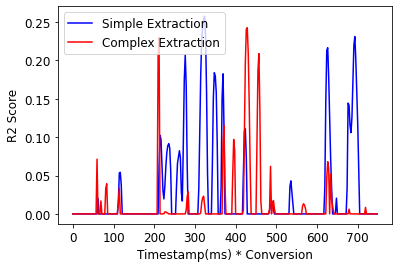

In [84]:
def plot_R2(time_stamps, R2_data, color, label, block_neg = False):
    
    R2_data = np.array(R2_data)
    print(type(R2_data[0]))
    if block_neg:
        R2_data[R2_data<0]=0
    
    fs = 12
    plt.plot(time_stamps * conversion, R2_data, color = color, label = label)
    plt.xlabel("Timestamp(ms) * Conversion", fontsize = fs)
    plt.ylabel("R2 Score", fontsize = fs)
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.legend(fontsize=fs)


plot_R2(np.arange(gfp_3d.shape[1]), simple_correlation, color = "blue", label = "Simple Extraction", block_neg = 1)
plot_R2(np.arange(gfp_3d.shape[1]), complex_correlation, color = "red", label = "Complex Extraction", block_neg = 1)
plt.show()


In [56]:
"""
pca_simple_unit_activation_3d = pca_simple_unit_activation_3d
pca_complex_unit_activation_3d = pca_complex_unit_activation_3d

#EEG_3d = EEG[:,1,:,:]

#Averaging the 128 electronodes 
#EEG_3d = np.mean(EEG_3d, axis = 2)  

print(pca_simple_unit_activation_3d.shape, EEG.shape, EEG_3d.shape)

simple_correlation = []
complex_correlation = []

for time_stamp in np.arange(EEG_3d.shape[1]):
    
    simple_correlation.append(linearmodel_EEG(pca_simple_unit_activation_3d, EEG_3d[:,time_stamp]))
    complex_correlation.append(linearmodel_EEG(pca_complex_unit_activation_3d, EEG_3d[:,time_stamp]))
    
    #break
    #simple_regr_model = linearmodel_EEG(pca_simple_unit_activation_3d, EEG_3d[:,time_stamp])
    #simple_correlation.append(simple_regr_model.score(pca_simple_unit_activation_3d, EEG_3d[:,time_stamp]))
    
    #complex_regr_model = linearmodel_EEG(pca_complex_unit_activation_3d, EEG_3d[:,time_stamp])
    #complex_correlation.append(complex_regr_model.score(pca_complex_unit_activation_3d,  EEG_3d[:,time_stamp]))
    
#print(simple_correlation)
best_ten_simple_timestamps = best_correlation(simple_correlation, 10)
best_ten_complex_timestamps = best_correlation(complex_correlation, 10)


print("Best tem_simple_timestamps:", best_ten_simple_timestamps)
print("Best tem_complex_timestamps:", best_ten_complex_timestamps)

print("Best 10 R2 values of simple_extraction")
for idx in best_ten_simple_timestamps:
    print(simple_correlation[idx])

print("Best 10 R2 values of complex_extraction")
for idx in best_ten_complex_timestamps:
    print(complex_correlation[idx])
    

print("R2 values of each time_stamps for simple_extraction:", simple_correlation)


"""


'\npca_simple_unit_activation_3d = pca_simple_unit_activation_3d\npca_complex_unit_activation_3d = pca_complex_unit_activation_3d\n\n#EEG_3d = EEG[:,1,:,:]\n\n#Averaging the 128 electronodes \n#EEG_3d = np.mean(EEG_3d, axis = 2)  \n\nprint(pca_simple_unit_activation_3d.shape, EEG.shape, EEG_3d.shape)\n\nsimple_correlation = []\ncomplex_correlation = []\n\nfor time_stamp in np.arange(EEG_3d.shape[1]):\n    \n    simple_correlation.append(linearmodel_EEG(pca_simple_unit_activation_3d, EEG_3d[:,time_stamp]))\n    complex_correlation.append(linearmodel_EEG(pca_complex_unit_activation_3d, EEG_3d[:,time_stamp]))\n    \n    #break\n    #simple_regr_model = linearmodel_EEG(pca_simple_unit_activation_3d, EEG_3d[:,time_stamp])\n    #simple_correlation.append(simple_regr_model.score(pca_simple_unit_activation_3d, EEG_3d[:,time_stamp]))\n    \n    #complex_regr_model = linearmodel_EEG(pca_complex_unit_activation_3d, EEG_3d[:,time_stamp])\n    #complex_correlation.append(complex_regr_model.score(pc